Importing required libraries

In [1]:
import os
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

# Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

#Matplotlib
import matplotlib.pyplot as plt

# Data management libraries
import scipy.io as scio
import numpy as np

Loading in the data

In [7]:
data_train = scio.loadmat('Data/tumor_train_data.mat')
data_val = scio.loadmat('Data/tumor_val_data.mat')
data_test = scio.loadmat('Data/tumor_test_data.mat')

#data_train = scio.loadmat('/content/tumor_train_data.mat')
#data_val = scio.loadmat('/content/tumor_val_data.mat')
#data_test = scio.loadmat('/content/tumor_test_data.mat')

N = 64 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

Checking Data

In [8]:
print(data_train['img_train'].shape)
print(data_train['labels_train'].shape)
print(data_val['img_val'].shape)
print(data_val['labels_val'].shape)
print(data_test['img_test'].shape)
print(data_test['labels_test'].shape)


(64, 64, 1958)
(1958, 1)
(64, 64, 654)
(654, 1)
(64, 64, 654)
(654, 1)


Visualisartion of data

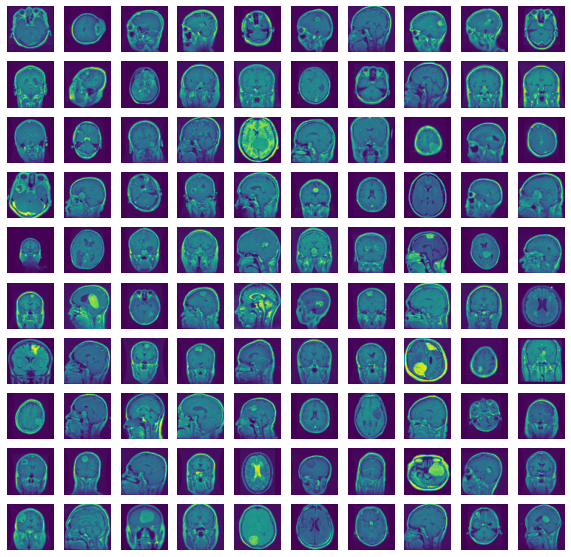

In [9]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

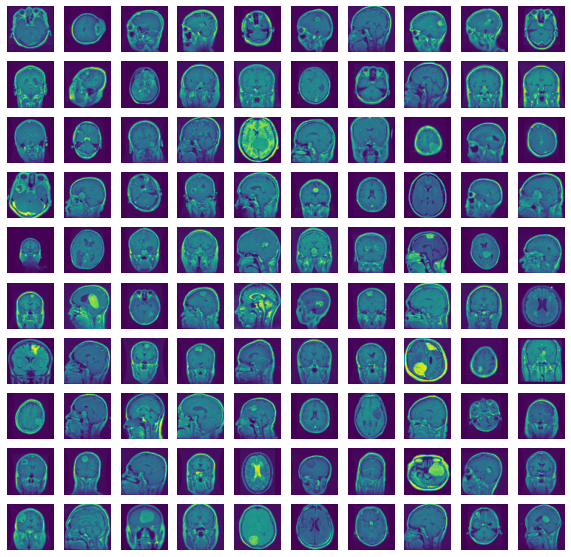

In [10]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')    

### Network Architecture

In [19]:
num_epochs = 30 # how many training epochs we are doing

# build model function
def build_model(num_classes, output_activation=None):
    # Input in an image shape
    inputs = keras.Input(shape=(N, N, 1, ), name='img')
    
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs) # consider using alternate activation
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    
    # Neuron setup
    x = layers.Dense(256, activation='relu')(x) # consider using alternate activation
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) # consider using alternate activation
    #x = layers.Dense(4, activation='softmax')(x)
    
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='tumor_classifier_cnn_model')
    
    return model_cnn

In [20]:
model_cnn = build_model(4)
model_cnn.summary()

Model: "tumor_classifier_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 spatial_dropout2d_6 (Spatia  (None, 64, 64, 16)       0         
 lDropout2D)                            

Training the model

In [21]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=40,
                        validation_data=(val, val_y))

Epoch 1/40
16/16 [==============================] - 8s 415ms/step - loss: 2.7796 - accuracy: 0.3611 - val_loss: 1.3780 - val_accuracy: 0.3104
Epoch 2/40
16/16 [==============================] - 7s 409ms/step - loss: 1.1475 - accuracy: 0.4724 - val_loss: 1.3790 - val_accuracy: 0.2523
Epoch 3/40
16/16 [==============================] - 7s 410ms/step - loss: 1.0687 - accuracy: 0.5138 - val_loss: 1.3766 - val_accuracy: 0.2706
Epoch 4/40
16/16 [==============================] - 6s 406ms/step - loss: 0.9624 - accuracy: 0.5797 - val_loss: 1.3948 - val_accuracy: 0.2508
Epoch 5/40
16/16 [==============================] - 6s 406ms/step - loss: 0.9212 - accuracy: 0.5776 - val_loss: 1.4026 - val_accuracy: 0.3303
Epoch 6/40
16/16 [==============================] - 6s 405ms/step - loss: 0.8948 - accuracy: 0.6083 - val_loss: 1.4274 - val_accuracy: 0.2508
Epoch 7/40
16/16 [==============================] - 7s 407ms/step - loss: 0.8529 - accuracy: 0.6129 - val_loss: 1.3726 - val_accuracy: 0.2554
Epoch 

### Model Evaluation

              precision    recall  f1-score   support

           0       0.86      0.83      0.84        98
           1       0.75      0.88      0.81       192
           2       0.87      0.68      0.76       185
           3       0.92      0.98      0.95       179

    accuracy                           0.84       654
   macro avg       0.85      0.84      0.84       654
weighted avg       0.85      0.84      0.84       654



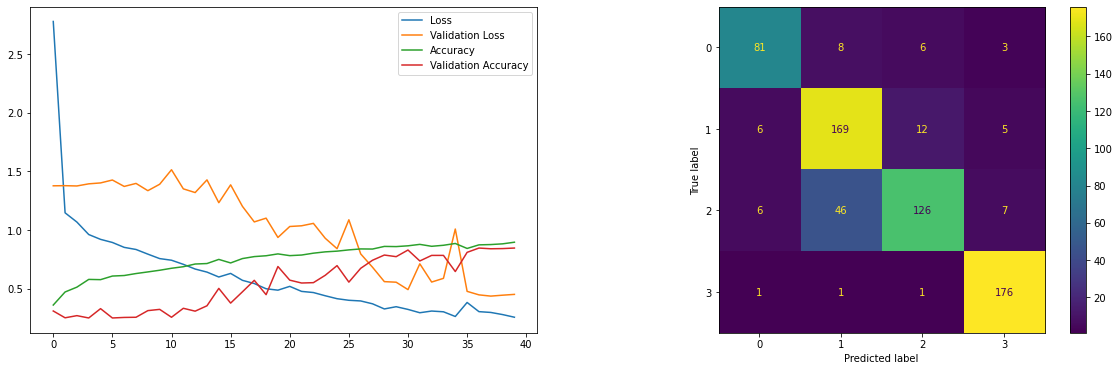

In [22]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(y_test))))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

eval_model(model_cnn, history.history, train, train_y, test, test_y)

### **AlexNet Model**

In [30]:
classes = ['glioma', 'miningioma', 'no tumour', 'pituitary']
num_epochs = 30 # how many training epochs we are doing


# def build_alexnet(num_classes, output_activation=None):

#     inputs = keras.Input(shape=(N, N, 1, ), name='img')

#     x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
#     x = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
#     x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(4096, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(4096, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(10, activation='softmax')
  
#     model_alex = keras.models.Sequential(inputs=inputs, outputs=outputs, name='tumor_classifier_cnn_model')

# model_alex = build_alexnet(num_classes)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(N,N,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])


In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=0.001),
              metrics=['accuracy'])
model.summary()
history = model.fit(train, train_y,
                        batch_size=100,
                        epochs=num_epochs,
                        validation_data=(val, val_y))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 14, 14, 96)        11712     
                                                                 
 batch_normalization_45 (Bat  (None, 14, 14, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 7, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 7, 7, 256)         614656    
                                                                 
 batch_normalization_46 (Bat  (None, 7, 7, 256)        1024      
 chNormalization)                                                
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 43s 2s/step - loss: 2.1392 - accuracy: 0.2891 - val_loss: 2.2819 - val_accuracy: 0.2630
Epoch 2/30
20/20 [==============================] - 47s 2s/step - loss: 1.5590 - accuracy: 0.4183 - val_loss: 2.2416 - val_accuracy: 0.2630
Epoch 3/30
20/20 [==============================] - 41s 2s/step - loss: 1.3033 - accuracy: 0.5010 - val_loss: 2.1840 - val_accuracy: 0.2630
Epoch 4/30
20/20 [==============================] - 41s 2s/step - loss: 1.2258 - accuracy: 0.5352 - val_loss: 2.1116 - val_accuracy: 0.2630
Epoch 5/30
20/20 [==============================] - 40s 2s/step - loss: 1.1189 - accuracy: 0.5664 - val_loss: 2.0413 - val_accuracy: 0.2630
Epoch 6/30
20/20 [==============================] - 41s 2s/step - loss: 1.0264 - accuracy: 0.5878 - val_loss: 1.9769 - val_accuracy: 0.2630
Epoch 7/30
20/20 [==============================] - 40s 2s/step - loss: 0.9445 - accuracy: 0.6307 - val_loss: 1.9297 - val_accuracy: 0.2630
Epoch 8/30
20/20 [=============